# TMDB MOVIES DATA ANALYSIS

In [2]:
# locating the Spark installation
import findspark
findspark.init()

In [3]:
# Start a spark session for the data analysis
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MovieAnalysis").getOrCreate()




In [5]:
# read the cleaned data from the parquet file
df = spark.read.parquet("../data/cleaned_movies_df.parquet")

# show the first 5 rows of the dataframe
df.show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+----------------+--------------------+--------------------+---------+--------------------+---------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+----------------+-------------------

In [6]:
# Summary statistics
df.describe().show()

+-------+------------------+-------+--------------------+--------------------+--------------------+-----------------+------------------+------------------+--------------------+--------------------+------------------+-------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+------------------+
|summary|                id|  title|             tagline|              genres|     collection_name|original_language|       budget_musd|      revenue_musd|production_companies|production_countries|        vote_count|       vote_average|        popularity|           runtime|            overview|    spoken_languages|         poster_path|          cast_names|        cast_size|           directors|         crew_size|
+-------+------------------+-------+--------------------+--------------------+--------------------+-----------------+------------------+------------------+-----------

## KPI Implementation & Analysis

Filter and rank movies based on:
* Highest Revenue
* Highest Budget
* Highest Profit (Revenue - Budget)
* Lowest Profit (Revenue - Budget)
* Highest ROI (Revenue / Budget) (only movies with Budget ≥ 10M)
* Lowest ROI (only movies with Budget ≥ 10M)
* Most Voted Movies
* Highest Rated Movies (only movies with ≥10 votes)
* Lowest Rated Movies (only movies with ≥10 votes)
* Most Popular Movies

Define a User-Defined Function (UDF) to streamline ranking operations

In [7]:
# Function for the ranking of movies
from pyspark.sql.functions import col

def rank_movies(df, sort_col, ascending=False, filter_condition=None, top_n=10):
    if filter_condition:
        df = df.filter(filter_condition)
    return df.orderBy(col(sort_col).asc() if ascending else col(sort_col).desc()).limit(top_n)

In [8]:
# create profit and roi columns
from pyspark.sql.functions import when, expr

df = df.withColumn("profit", col("revenue_musd") - col("budget_musd"))\
       .withColumn("roi", when(col("budget_musd") >= 10, col("revenue_musd") / col("budget_musd")))


### Highest Revenue:

In [11]:
# Highest Revenue
rank_movies(df, "revenue_musd").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+------------------+------------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size|            profit|               roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+-----

### Highest Budget:


In [12]:
# Highest Budget
rank_movies(df, "budget_musd").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+----------------+--------------------+--------------------+---------+--------------------+---------+------------------+-----------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size|            profit|              roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+--

### Highest Profit:

In [13]:
# Highest Profit
rank_movies(df, "profit").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+------------------+------------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size|            profit|               roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+-----

### Lowest Profit:

In [14]:
# Highest Profit
rank_movies(df, "profit", ascending=True).show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+----------------+--------------------+--------------------+---------+--------------------+---------+-------+-----------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size| profit|              roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+-----

### Highest ROI:

In [15]:
# Highest ROI (Budget ≥ 10M)
rank_movies(df, "roi", filter_condition="budget_musd >= 10").show(5)


+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+-------+------------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size| profit|               roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+---

### Lowest ROI:

In [16]:
# Lowest ROI (Budget ≥ 10M)
rank_movies(df, "roi", ascending=True, filter_condition="budget_musd >= 10").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------------+--------------------+--------------------+---------+------------+---------+-------+-----------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|          spoken_languages|         poster_path|          cast_names|cast_size|   directors|crew_size| profit|              roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+-

### Most Voted Movies:

In [19]:
# Most Voted Movies
rank_movies(df, "vote_count").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+-------+------------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size| profit|               roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+---

### Highest Rated Movies:

In [20]:
# Highest Rated (only movies with ≥ 10 votes)
rank_movies(df, "vote_average", filter_condition="vote_count >= 10").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+-------+------------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size| profit|               roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+---

### Lowest Rated Movies

In [22]:
# Lowest Rated (only movies with ≥ 10 votes)
rank_movies(df, "vote_average", ascending=True, filter_condition="vote_count >= 10").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+----------------+--------------------+--------------------+---------+---------------+---------+-------+-----------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|spoken_languages|         poster_path|          cast_names|cast_size|      directors|crew_size| profit|              roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+---------------

### Most Popular Movies

In [24]:
# Most Popular
rank_movies(df, "popularity").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------------+--------------------+--------------------+---------+--------------------+---------+-------+-----------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|          spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size| profit|              roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----

## Franchise vs. Standalone Movie Performance

Compare movie franchises (belongs_to_collection) vs. standalone movies in terms
of:
* Mean Revenue
* Median ROI
* Mean Budget Raised
* Mean Popularity
* Mean Rating

In [36]:
# function to compare franchise vs standalone movies
from pyspark.sql.functions import col, avg, when, expr, count, lit, percentile_approx, explode, split, trim, sum as _sum

def compare_franchise_vs_standalone(df):
    # Create is_franchise column
    df = df.withColumn("is_franchise", when(col("collection_name") != "", lit("Franchise")).otherwise("Standalone"))
    
    # Add ROI column if not already added
    df = df.withColumn("roi", when(col("budget_musd") >= 10, col("revenue_musd") / col("budget_musd")))
    
    # Group by is_franchise and compute metrics
    result = df.groupBy("is_franchise").agg(
        avg("revenue_musd").alias("mean_revenue"),
        percentile_approx("roi", 0.5).alias("median_roi"),
        avg("budget_musd").alias("mean_budget"),
        avg("popularity").alias("mean_popularity"),
        avg("vote_average").alias("mean_rating")
    )
    
    return result


In [37]:
# compare franchise vs standalone movies
compare_franchise_vs_standalone(df).show(truncate=False)


+------------+------------------+-----------------+-----------+---------------+-----------------+
|is_franchise|mean_revenue      |median_roi       |mean_budget|mean_popularity|mean_rating      |
+------------+------------------+-----------------+-----------+---------------+-----------------+
|Franchise   |1682.643125       |7.708647058823529|219.875    |33.03605       |7.3798125        |
|Standalone  |1765.1399999999999|7.91325          |180.0      |47.7778        |7.438000000000001|
+------------+------------------+-----------------+-----------+---------------+-----------------+



## Most Successful Franchises & Directors

Find the Most Successful Movie Franchises based on:
* Total number of movies in franchise
* Total & Mean Budget
* Total & Mean Revenue
* Mean Rating

In [38]:
# Function for analysing sucessful franchises
def analyze_successful_franchises(df):
    # Filter only franchise movies (non-empty collection_name)
    franchise_df = df.filter(col("collection_name") != "")

    # Group by franchise and compute metrics
    result = franchise_df.groupBy("collection_name").agg(
        count("*").alias("movie_count"),
        _sum("budget_musd").alias("total_budget_musd"),
        avg("budget_musd").alias("mean_budget_musd"),
        _sum("revenue_musd").alias("total_revenue_musd"),
        avg("revenue_musd").alias("mean_revenue_musd"),
        avg("vote_average").alias("mean_rating")
    ).orderBy(col("total_revenue_musd").desc())

    return result

In [39]:
analyze_successful_franchises(df).show(truncate=False)


+-----------------------------------+-----------+-----------------+----------------+------------------+------------------+------------------+
|collection_name                    |movie_count|total_budget_musd|mean_budget_musd|total_revenue_musd|mean_revenue_musd |mean_rating       |
+-----------------------------------+-----------+-----------------+----------------+------------------+------------------+------------------+
|The Avengers Collection            |4          |1241.0           |310.25          |7776.080000000001 |1944.0200000000002|7.8614999999999995|
|Star Wars Collection               |2          |445.0            |222.5           |3400.92           |1700.46           |7.02              |
|Jurassic Park Collection           |2          |320.0            |160.0           |2982.01           |1491.005          |6.615             |
|Avatar Collection                  |1          |237.0            |237.0           |2923.71           |2923.71           |7.588             |
|Froze

Find the Most Successful Directors based on:
* Total Number of Movies Directed
* Total Revenue
* Mean Rating

In [ ]:
# Function for analysing sucessful directors
def analyze_successful_directors(df):
    # Split string into array and trim whitespace
    directors_df = df.withColumn("director", explode(split(col("directors"), "\\|"))).withColumn("director", trim(col("director")))

    # Group by individual director
    result = directors_df.groupBy("director").agg(
        count("*").alias("movie_count"),
        _sum("revenue_musd").alias("total_revenue_musd"),
        avg("vote_average").alias("mean_rating")
    ).orderBy(col("total_revenue_musd").desc())

    return result



In [41]:
analyze_successful_directors(df).show(truncate=False)


+---------------+-----------+------------------+-----------+
|director       |movie_count|total_revenue_musd|mean_rating|
+---------------+-----------+------------------+-----------+
|James Cameron  |2          |5187.87           |7.7465     |
|Joe Russo      |2          |4851.860000000001 |8.2175     |
|Anthony Russo  |2          |4851.860000000001 |8.2175     |
|Joss Whedon    |2          |2924.2200000000003|7.5055     |
|Chris Buck     |2          |2727.9            |7.248      |
|Jennifer Lee   |2          |2727.9            |7.248      |
|J.J. Abrams    |1          |2068.22           |7.262      |
|Colin Trevorrow|1          |1671.54           |6.693      |
|Jon Favreau    |1          |1662.02           |7.11       |
|James Wan      |1          |1515.4            |7.226      |
|Ryan Coogler   |1          |1349.93           |7.4        |
|David Yates    |1          |1341.51           |8.087      |
|Rian Johnson   |1          |1332.7            |6.778      |
|J.A. Bayona    |1      

## Data Visualisation

Visualise:
* Revenue vs. Budget Trends
* ROI Distribution by Genre     
* Popularity vs. Rating
* Yearly Trends in Box Office Performance
* Comparison of Franchise vs. Standalone Success

In [42]:
# conveting the Spark DataFrame to Pandas DataFrame for further analysis
def to_pandas(df, sample_frac=1.0):
    return df.sample(fraction=sample_frac).toPandas()


### Revenue vs. Budget Trend

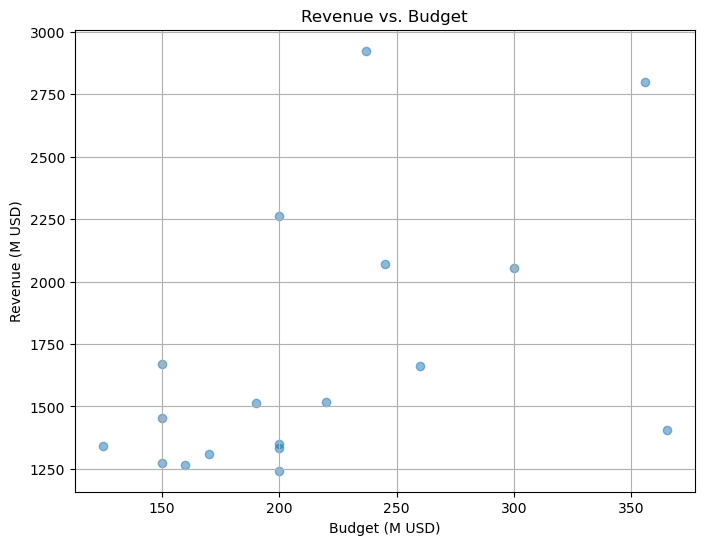

In [43]:
import matplotlib.pyplot as plt

# Prepare data
rev_budget_df = df.select("budget_musd", "revenue_musd").filter((col("budget_musd") > 0) & (col("revenue_musd") > 0))
pd_rev_budget = to_pandas(rev_budget_df)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(pd_rev_budget["budget_musd"], pd_rev_budget["revenue_musd"], alpha=0.5)
plt.xlabel("Budget (M USD)")
plt.ylabel("Revenue (M USD)")
plt.title("Revenue vs. Budget")
plt.grid(True)
plt.show()


### ROI Distribution by Genre

<Figure size 1000x600 with 0 Axes>

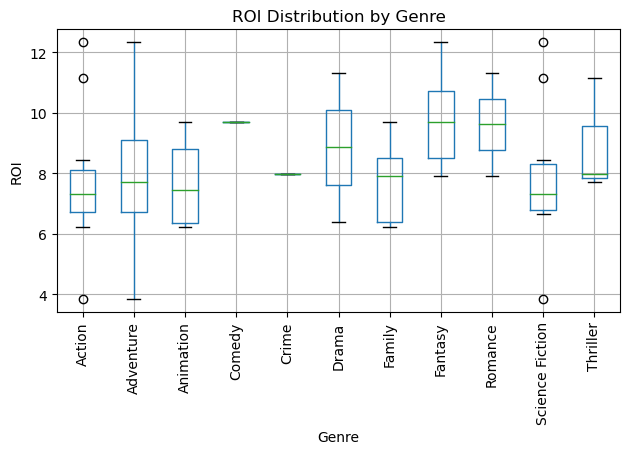

In [46]:
from pyspark.sql.functions import explode, split

# Explode genres into separate rows
roi_genre_df = df.withColumn("genre", explode(split(col("genres"), "\\|")))\
                 .select("genre", "roi")\
                 .filter(col("roi").isNotNull())

pd_roi_genre = to_pandas(roi_genre_df)

# Plot
plt.figure(figsize=(10, 6))
pd_roi_genre.boxplot(by="genre", column=["roi"], rot=90)
plt.title("ROI Distribution by Genre")
plt.suptitle("")  # remove automatic title
plt.xlabel("Genre")
plt.ylabel("ROI")
plt.grid(True)
plt.tight_layout()
plt.show();


### Popularity vs. Rating

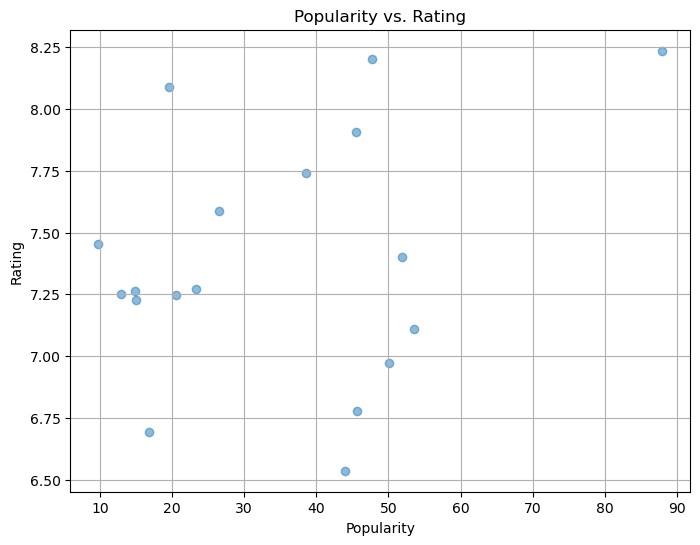

In [47]:
pop_rating_df = df.select("popularity", "vote_average").filter((col("popularity").isNotNull()) & (col("vote_average").isNotNull()))
pd_pop_rating = to_pandas(pop_rating_df)

plt.figure(figsize=(8, 6))
plt.scatter(pd_pop_rating["popularity"], pd_pop_rating["vote_average"], alpha=0.5)
plt.xlabel("Popularity")
plt.ylabel("Rating")
plt.title("Popularity vs. Rating")
plt.grid(True)
plt.show()


### Yearly Trends in Box Office Performance

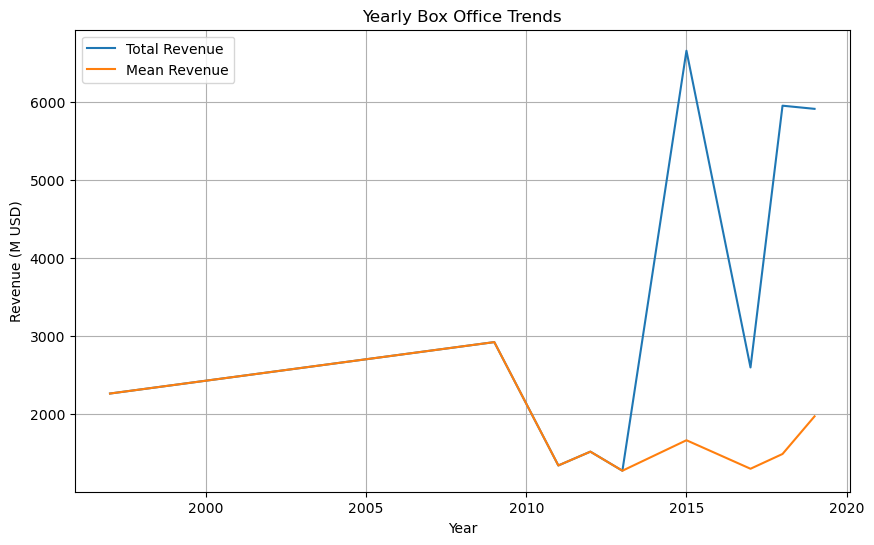

In [48]:
from pyspark.sql.functions import year

# Extract year
year_df = df.withColumn("year", year("release_date"))\
            .groupBy("year")\
            .agg(_sum("revenue_musd").alias("total_revenue"),
                 avg("revenue_musd").alias("mean_revenue"))\
            .orderBy("year")

pd_year = to_pandas(year_df)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(pd_year["year"], pd_year["total_revenue"], label="Total Revenue")
plt.plot(pd_year["year"], pd_year["mean_revenue"], label="Mean Revenue")
plt.xlabel("Year")
plt.ylabel("Revenue (M USD)")
plt.title("Yearly Box Office Trends")
plt.legend()
plt.grid(True)
plt.show()


### Franchise vs. Standalone Comparison

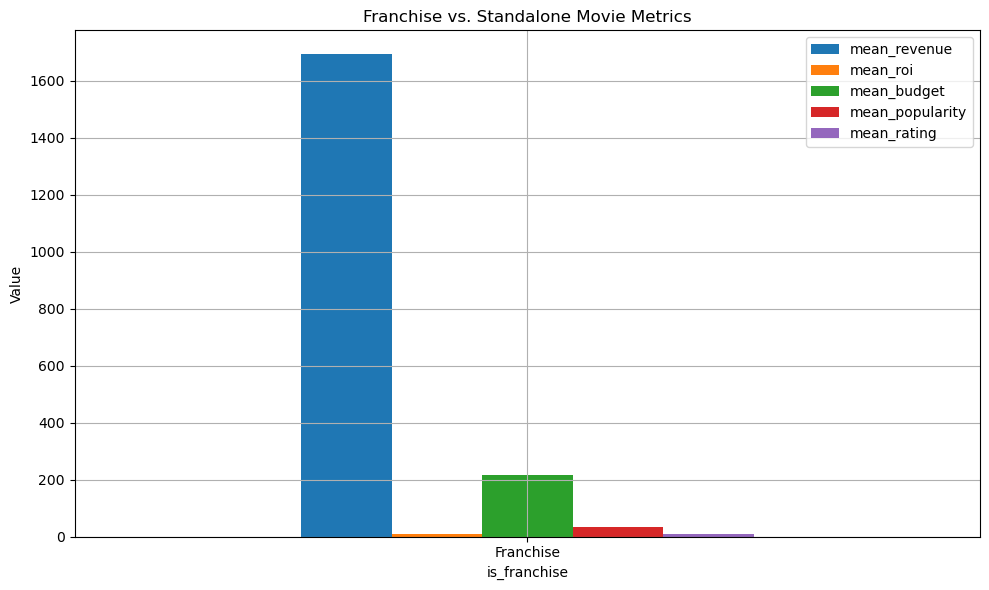

In [49]:
from pyspark.sql.functions import when

# Label franchise/standalone
franchise_df = df.withColumn("is_franchise", when(col("collection_name").isNotNull(), "Franchise").otherwise("Standalone"))\
                 .groupBy("is_franchise")\
                 .agg(
                     avg("revenue_musd").alias("mean_revenue"),
                     avg("roi").alias("mean_roi"),
                     avg("budget_musd").alias("mean_budget"),
                     avg("popularity").alias("mean_popularity"),
                     avg("vote_average").alias("mean_rating")
                 )

pd_franchise = to_pandas(franchise_df)

# Plot comparison
metrics = ["mean_revenue", "mean_roi", "mean_budget", "mean_popularity", "mean_rating"]
pd_franchise.set_index("is_franchise")[metrics].plot(kind="bar", figsize=(10, 6))
plt.title("Franchise vs. Standalone Movie Metrics")
plt.ylabel("Value")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()
